In [0]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

In [0]:
import numpy as np
from matplotlib import pyplot as plt

In [29]:
!pip install mxnet

In [0]:
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.gluon import rnn
from mxnet import autograd as ag
import mxnet.ndarray as F

## 前処理

In [0]:
# 事前にGoogle Driveをマウントして以下の場所にdate.txtを格納しておく
file_path = "nlp_sample.txt"

input_date = [] # 変換前の日付データ
output_date = [] # 変換後の日付データ

# date.txtを1行ずつ読み込んで変換前と変換後に分割して、inputとoutputで分ける
with open(file_path, "r") as f:
  date_list = f.readlines()
  for date in date_list:
    date = date[:-1]
    input_date.append(date.split("_")[0])
    output_date.append("_" + date.split("_")[1])

In [32]:
print("num of sentence: ", len(input_date))

num of sentence:  50000


In [0]:
input_date = input_date[:500]
output_date = output_date[:500]

In [0]:
# inputとoutputの系列の長さを取得
# すべて長さが同じなので、0番目の要素でlenを取ってます
input_len = len(input_date[0]) # 29
output_len = len(output_date[0]) # 10

In [0]:
# date.txtで登場するすべての文字にIDを割り当てる
char2id = {c:i for i, c in\
            enumerate(set(list("".join((input_date + output_date)))))}

input_data = [] # ID化された変換前日付データ
output_data = [] # ID化された変換後日付データ
for input_chars, output_chars in zip(input_date, output_date):
  input_data.append([char2id[c] for c in input_chars])
  output_data.append([char2id[c] for c in output_chars])

In [0]:
# 7:3でtrainとtestに分ける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)

# データをバッチ化するための関数を定義
def train2batch(input_data, output_data, batch_size=100):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
      input_batch.append(input_shuffle[i:i+batch_size])
      output_batch.append(output_shuffle[i:i+batch_size])
    return input_batch, output_batch

## パラメータ設定

In [0]:
embedding_dim = 200
hidden_dim = 128
BATCH_NUM = 100
vocab_size = len(char2id)

In [0]:
epoch = 100

## Encoderの設定

In [0]:
class Encoder(gluon.Block):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, batch_size=100, **kwargs):
      super(Encoder, self).__init__(**kwargs)
      with self.name_scope():
          self.hidden_dim = hidden_dim
          self.num_layers = num_layers
          self.batch_size = batch_size

          self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
          self.gru = rnn.GRU(hidden_dim, input_size=embedding_dim, layout="NTC")

  def forward(self, sequence):
      embedding = self.word_embeddings(sequence)
      # state.size() = (num_layers, batch_size, num_hidden)
      begin_state = mx.nd.random.uniform(shape=(self.num_layers, self.batch_size, self.hidden_dim))
      hs, h = self.gru(embedding, begin_state)
      return hs, h

In [0]:
class AttentionDecoder(gluon.Block):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size, **kwargs):
      super(AttentionDecoder, self).__init__(**kwargs)
      with self.name_scope():
          self.hidden_dim = hidden_dim
          self.batch_size = batch_size

          self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
          self.gru = rnn.GRU(hidden_dim, input_size=embedding_dim, layout="NTC")
          #各系列のGRUの隠れ層とAttention層で計算したコンテ
          # hidden_dim*2としているのはキストベクトルをtorch.catでつなぎ合わせることで長さが２倍になるため
          #self.hidden2linear = nn.Dense(vocab_size, in_units=hidden_dim * 2)
          self.hidden2linear = nn.Dense(vocab_size, in_units=hidden_dim * 2, flatten=False)

  def forward(self, sequence, hs, h):
      embedding = self.word_embeddings(sequence)
      output, state = self.gru(embedding, h)

      # Attention層
      # hs.size() = ([batch_size, 29, hidden_dim])
      # output.size() = ([batch_size, 10, hidden_dim])

      # bmmを使ってEncoder側の出力(hs)とDecoder側の出力(output)を
      # batchごとまとめて行列計算するために、Decoder側のoutputを
      # batchを固定して転置行列を取る
      # t_output.size() = ([batch_size, hidden_dim, 10])
      
      t_output = mx.ndarray.transpose(output, axes=(0,2,1))
      # s.size() = ([batch_size, 29, 10])
      s = mx.ndarray.linalg.gemm2(hs, t_output)
      
      # 列方向で和
      # attention_weight.size() = ([100, 29, 10])
      attention_weight = mx.nd.softmax(s, axis=1)

      # コンテキストベクトルをまとめるために入れ物を用意
      # c.size() = ([batch_size, 1, hidden_dim])
      
      c = mx.ndarray.zeros((self.batch_size, 1, self.hidden_dim))

      
      # 各層（Decoder側のGRU層は生成文字列が10文字なので10個ある）
      #におけるattention weightを取り出してforループ内でコンテキスト
      # ベクトルを１つずつ作成する
      # バッチ方向はまとめて計算できたのでバッチはそのまま
      
      for i in range(attention_weight.shape[2]): # 10回ループ

        # attention_weight[:,:,i].size() = ([batch_size, 29])
        # i番目のGRU層に対するattention weightを取り出すが、テンソルの
        # サイズをhsと揃えるためにunsqueezeする
        # unsq_weight.size() = ([batch_size, 29, 1])
        unsq_weight = attention_weight[:,:,i].reshape(attention_weight.shape[0],\
                                              attention_weight.shape[1], 1)

        # hsの各ベクトルをattention weightで重み付けする
        # weighted_hs.size() = ([batch_size, 29, hidden_num])
        weighted_hs = hs * unsq_weight 
        
        # attention weightで重み付けされた各hsのベクトルをすべて足し合わせて
        # コンテキストベクトルを作成
        # weight_sum.size() = ([batch_size, 1, hidden_num])
        weight_sum = mx.nd.sum(weighted_hs, axis=1).reshape(self.batch_size,\
                                                                1, self.hidden_dim)
        
        # c.size() = ([batch_size, i, hidden_num])
        c = mx.ndarray.concat(c, weight_sum, dim=1)
      
      # 箱として用意したzero要素が残っているのでスライスして削除
      # output.size() = ([batch_size, 10, hidden_dim*2])
      
      c = c[:,1:,:]
      output = mx.nd.concat(output, c, dim=2)
      output = self.hidden2linear(output)

      return output, state, attention_weight

In [0]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim)
attn_decoder = AttentionDecoder(vocab_size, embedding_dim, hidden_dim, BATCH_NUM)

In [42]:
encoder.summary

<bound method Block.summary of Encoder(
  (word_embeddings): Embedding(59 -> 200, float32)
  (gru): GRU(200 -> 128, NTC)
)>

In [43]:
attn_decoder.summary

<bound method Block.summary of AttentionDecoder(
  (word_embeddings): Embedding(59 -> 200, float32)
  (gru): GRU(200 -> 128, NTC)
  (hidden2linear): Dense(256 -> 59, linear)
)>

In [0]:
# set the context on GPU is available otherwise CPU
ctx = [mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()]
encoder.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
encoder_trainer = gluon.Trainer(encoder.collect_params(), 'sgd', {'learning_rate': 0.03})

In [0]:
# set the context on GPU is available otherwise CPU
ctx = [mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()]
attn_decoder.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
attn_decoder_trainer = gluon.Trainer(attn_decoder.collect_params(), 'sgd', {'learning_rate': 0.03})

In [0]:
# 損失関数
criterion = gluon.loss.SoftmaxCrossEntropyLoss()

In [0]:
train_x = np.array(train_x)
train_y = np.array(train_y)

In [48]:
print(np.array(train_x).shape)
print(np.array(train_y).shape)

(350, 29)
(350, 11)


In [0]:
train_data = mx.io.NDArrayIter(train_x, train_y, BATCH_NUM, shuffle=False)

In [50]:
loss_log = []
for i in range(epoch):
  train_data.reset()
  for batch in train_data:
      data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
      label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)

      with ag.record():
          for x, y in zip(data, label):
              hs, h = encoder(x)

              # Attention Decoderのインプット
              source = y[:, :-1]
              # Attention Decoderの正解データ
              target = y[:, 1:]

              decoder_output, _, attention_weight= attn_decoder(source, hs, h)
              #output = attn_decoder(source, hs, h)

              loss = []
              for j in range(decoder_output.shape[1]):
                  loss.append(criterion(decoder_output[:, j, :], target[:, j]))

              loss_sum = sum(loss)
              loss_sum.backward()

      encoder_trainer.step(batch.data[0].shape[0])
      attn_decoder_trainer.step(batch.data[0].shape[0])

  loss_sum_sum = sum(loss_sum).asnumpy()[0]
  loss_log.append(loss_sum_sum)
  if i % 10 == 0:
      print("epoch_{i} loss: {loss}".format(i=i, loss=loss_sum_sum))

epoch_0 loss: 3755.5595703125
epoch_10 loss: 1972.5611572265625
epoch_20 loss: 1464.1612548828125
epoch_30 loss: 1333.322021484375
epoch_40 loss: 1201.8514404296875
epoch_50 loss: 1138.8641357421875
epoch_60 loss: 1106.321533203125
epoch_70 loss: 1076.081298828125
epoch_80 loss: 1050.4949951171875
epoch_90 loss: 1033.99755859375


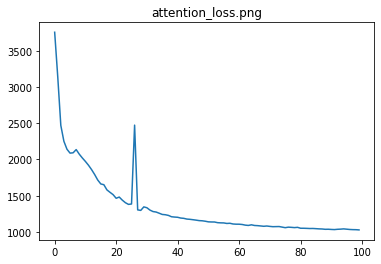

In [54]:
plt.title("attention_loss.png")
plt.plot(loss_log)